In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Upload the train file from your local drive
from google.colab import files
uploaded = files.upload()


Saving weather_data.csv to weather_data.csv


In [87]:
df = pd.read_csv("weather_data.csv", usecols = ['temp', 'pressure', 'humidity', 'wind_speed', 'weather_id'])
#df['dt_iso']= df['dt_iso'].apply(lambda x: x[:19])

In [99]:
from sklearn.preprocessing import MinMaxScaler

split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 1
past = 120
future = 1
learning_rate = 0.001
batch_size = 256
epochs = 10

# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(df)
df = pd.DataFrame(dataset)

train_data = df.loc[0 : train_split - 1]
val_data = df.loc[train_split:]

start = past + future
end = start + train_split

x_train = train_data[[1,2,3,4]].values
y_train = df.iloc[start:end][[0]]

print(x_train.shape)
print(y_train.shape)

sequence_length = int(past / step)

(267263, 4)
(267263, 1)


In [100]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


In [101]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[1,2,3,4]].values
y_val = df.iloc[label_start:][[0]]


dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 4)
Target shape: (256, 1)


In [102]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32, dropout=0.2)(inputs)
dense_outputs = keras.layers.Dense(24)(lstm_out)
outputs = keras.layers.Dense(1)(dense_outputs)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 120, 4)]          0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 32)                4736      
_________________________________________________________________
dense_23 (Dense)             (None, 24)                792       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 25        
Total params: 5,553
Trainable params: 5,553
Non-trainable params: 0
_________________________________________________________________


In [103]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
1044/1044 [==============================] - 49s 46ms/step - loss: 0.0815 - val_loss: 0.0496

Epoch 00001: val_loss improved from inf to 0.04961, saving model to model_checkpoint.h5
Epoch 2/10
1044/1044 [==============================] - 49s 47ms/step - loss: 0.0653 - val_loss: 0.0423

Epoch 00002: val_loss improved from 0.04961 to 0.04230, saving model to model_checkpoint.h5
Epoch 3/10
1044/1044 [==============================] - 48s 46ms/step - loss: 0.0568 - val_loss: 0.0390

Epoch 00003: val_loss improved from 0.04230 to 0.03901, saving model to model_checkpoint.h5
Epoch 4/10
1044/1044 [==============================] - 48s 46ms/step - loss: 0.0514 - val_loss: 0.0376

Epoch 00004: val_loss improved from 0.03901 to 0.03761, saving model to model_checkpoint.h5
Epoch 5/10
1044/1044 [==============================] - 48s 46ms/step - loss: 0.0485 - val_loss: 0.0355

Epoch 00005: val_loss improved from 0.03761 to 0.03552, saving model to model_checkpoint.h5
Epoch 6/10
1044/104

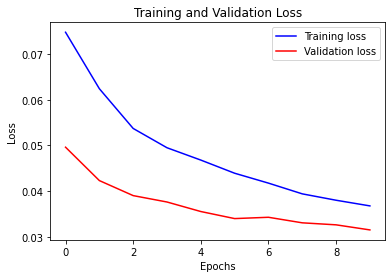

[0.07477680593729019, 0.06241186335682869, 0.05371076241135597, 0.049485523253679276, 0.046785760670900345, 0.0439065620303154, 0.04174060374498367, 0.03938976675271988, 0.03799208998680115, 0.03675280511379242]


In [104]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")
print(history.history["loss"])